# Part 2: Convolutional Neural Networks

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

In [32]:
import os, re, math, json, shutil, pprint
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import pathlib
from skimage import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.callbacks import History
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

2.8.2


In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
from os import listdir
from os.path import isfile, join

images = []
labels = []
dataset_path = './MLBD-dataset-IML-2022-Anglo-Saxion-Runes/'
for file_name in listdir(dataset_path):
    full_path = join(dataset_path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path, as_gray=True)
            image_label = file_name.split('_')[0].lower()
            # append to the array
            images.append(image_current)
            labels.append(image_label)

Data imbalance 

In the next cell we are going to check for any imbalance in our data

In [35]:
# from collections import Counter

# counter = Counter(labels)
# for k,v in counter.items():
#     per = v / len(labels) * 100
#     print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plt.bar(counter.keys(), counter.values())
# plt.show()

We knew from the previous course that the dataset is quite balanced and therefore we will not perform any balancing techniques on the dataset.

We are going to split our data using the train_test_split function from sklearn. We will use 20% of the data for validation and 80% for training.

In [36]:
from sklearn.model_selection import train_test_split

# LabelEncoder().fit_transform(y)

encoded_labels = keras.utils.to_categorical(LabelEncoder().fit_transform(labels))

X_train, X_test, y_train, y_test = train_test_split(np.array(images), np.array(encoded_labels), test_size=0.2, random_state=123)

We are going to use the following utility function to plot the training and validation loss and accuracy of our models.

In [37]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.ylim(-0.1, 1.1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

We are going to train our models with 20 epochs of 32 batch size.

The reason of using 32 a batch size of 32 is that the dataset is small and from the sources that we have used we have found that 32 is a good batch size for small datasets. Nevertheless, the epoch are the way the models are improving and having a bigger batch size would not make a big difference unless we have a larger dataset.

Later we will create an early stopper to stop the training when our model is not improving.

source:
- https://stackoverflow.com/a/38405970
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [38]:
EPOCHS = 20
BATCH_SIZE = 32

Basic method to define the structure of the convolutional neural network

Our structure consists of the following:

1. Input layer with the shape of the image (128, 128, 1)
2. (layers) that would be defined later
3. Flatten layer to flatten the output of the previous layers
4. Dense layer with 512 neurons and relu activation function
5. Desnse layer for our output with 11 neurons (which represents the runes) and softmax activation function

As you can observe, we use the adam optimizer (with default learning rate of 0.001) and the categorical crossentropy loss function and using the metrics for the accuracy.

source: 
- https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

In [39]:
def create_model(layers=[], kernel_size =(3, 3), debug=False):
    model = tf.keras.models.Sequential()
    # Define the input layer 1 channel
    model.add(tf.keras.layers.Input(shape=(128, 128, 1))) 
    
    # Adding convolutional layers
    for layer in layers:
        model.add(layer)

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    # Define the fully connected layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    # Output layer with 11 neurons as we have 11 runes to classify
    # which is using the softmax activation function
    model.add(tf.keras.layers.Dense(11, activation='softmax'))

    if (debug):
        model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We're also using the early stopping callback to stop the training if the loss is not decreasing for 3 epochs.

source:
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
- https://pub.towardsai.net/keras-earlystopping-callback-to-train-the-neural-networks-perfectly-2a3f865148f7

In [40]:
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='accuracy', baseline=98, patience=3, verbose=1)

In our experiments we are going to use a kernel size of (3,3) for all convolutional layers as we are trying to find local patterns in our runes and preserv the information in the image.
- source: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

In [41]:
kernel_size = (3, 3)

At the same time we would use the Conv2D layer with a certain number fo neurons (64 in this example which would change for some experiments), kernel size of (3,3), which has been defined above and relu activation function.
We are adding the padding same as we would like to capture as much information as possible from the image, even in the corners, where the padding is helpful.

source: 
- https://www.geeksforgeeks.org/keras-conv2d-class/
- https://keras.io/api/layers/convolution_layers/convolution2d/

In [42]:
tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same')

Something that we have noticed during our experiments is that the MaxPooling is boosting the training speed, quite a lot. Then we started reading about it turns out that the MaxPooling is a pooling layer that is used after a convolutional layer. It is used to reduce the spatial dimensions of the output volume of the convolutional layer. It is used to reduce the number of parameters and computation in the network, and hence to also control overfitting. It is also used to some degree to make feature detectors more invariant to their position in the input. 

Therefore, we are going to use the MaxPooling layer with a pool size of (2,2) which would reduce the size of the image by half.


Alex laptop's specifications:
- CPU: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz   2.80 GHz
- RAM: 16.0 GB
- GPU: NVIDIA T500

with this pc configuration we noticed that it takes around ~1 hour to train the model with 15 epochs of 32 batch size, without the MaxPooling layer. We attached a screenshot of the training process.

![Training](./experiment_1_no_maxpooling.png)
![Results](./experiment_1_no_maxpooling_results.png)

source:
- https://paperswithcode.com/method/max-pooling#:~:text=Max%20Pooling%20is%20a%20pooling,used%20after%20a%20convolutional%20layer.
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [43]:
tf.keras.layers.MaxPooling2D((2, 2)),

(<keras.layers.pooling.MaxPooling2D at 0x243455aa340>,)

Learning Rate Scheduler
We are going to use a learning rate scheduler to adapt our learning rate each epoch iteration so that we can adjust our learning rate accordingly. From the tests that we conduceted we realized that our model is overfitting quite easy therefore we picked the step decay to decrease the learning rate. 

source:
- https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

In [44]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [45]:
def learning_rate_scheduler():
  return tf.keras.callbacks.LearningRateScheduler(step_decay)

Stores the model and the history of the training

In [46]:
models_and_history = []

# Experiment 1

In the first experiment, we are going to use the following layers:
2 Conv2D layers with 32 filters and 3x3 kernel size and relu activation function

Epoch 1/20
76/76 [==============================] - 49s 627ms/step - loss: 1.8928 - accuracy: 0.6295 - val_loss: 0.4072 - val_accuracy: 0.8927
Epoch 2/20
76/76 [==============================] - 49s 647ms/step - loss: 0.1325 - accuracy: 0.9612 - val_loss: 0.2550 - val_accuracy: 0.9323
Epoch 3/20
76/76 [==============================] - 50s 662ms/step - loss: 0.0256 - accuracy: 0.9942 - val_loss: 0.2517 - val_accuracy: 0.9406
Epoch 3: early stopping
76/76 [==============================] - 12s 157ms/step - loss: 0.0067 - accuracy: 1.0000


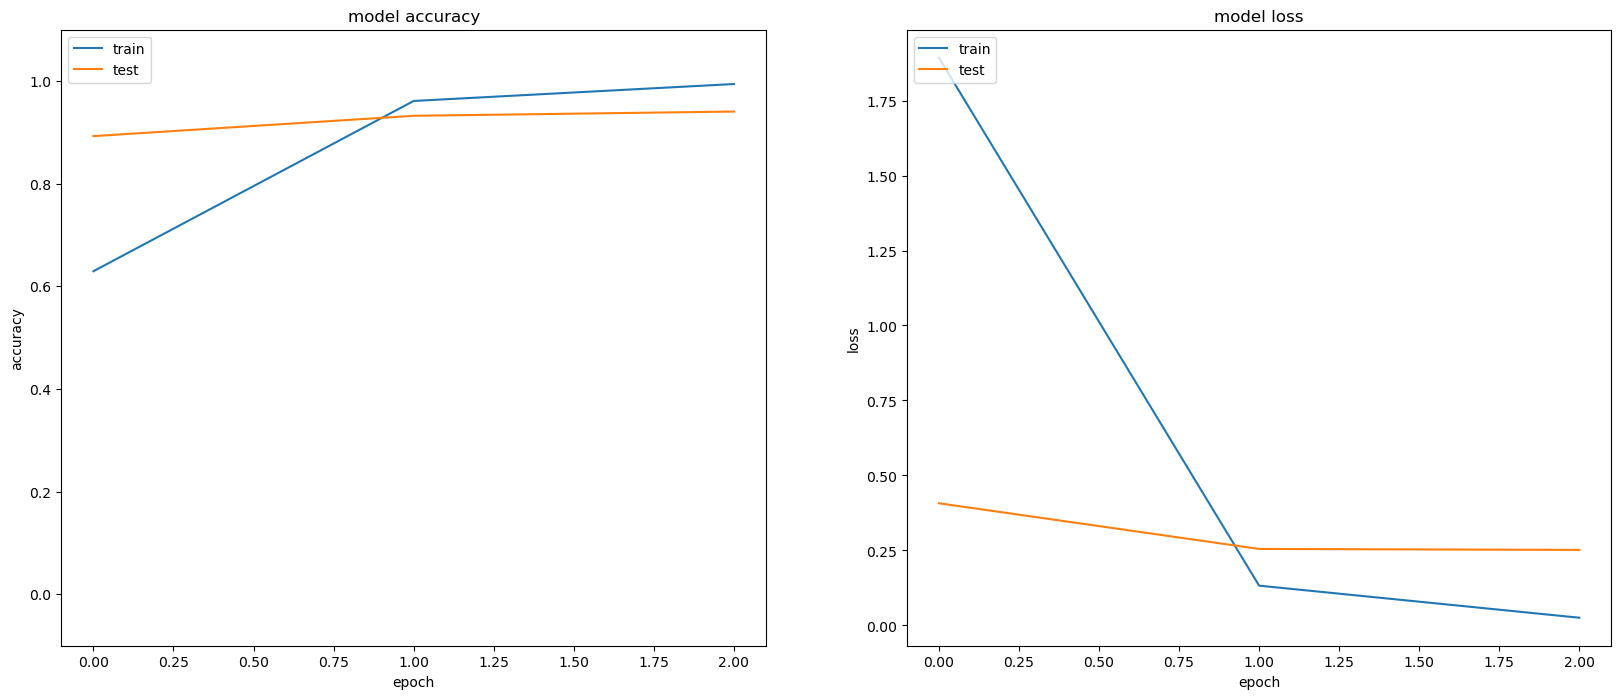

In [47]:
model = create_model(layers=[
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Our first model looks like it's overfitting in the first epochs, but it's not the case. We can see that the validation loss is decreasing and the validation accuracy is increasing. We can also see that the training loss is decreasing and the training accuracy is increasing.
As far as we have noticed during the training our model is overffiting from the 4th epoch. We can see that the loss reached a global low and an accuracy of 1.00. But from the 5th we can see that the val_accuracy is not increasing anymore, until the 12th epoch. 

Takeaway:
As a takeaway from this experiment is that we will change the early stopping callback to stop the training if the validation accuracy is not increasing for 2 epochs.

In [48]:
def early_stopping_v2():
    return tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

# Experiment 2

In this experiment we have increased the number of neurons to 64 to see if we can get better results. Also, we added the new early stopping callback to stop the training if the validation accuracy is not increasing for 3 epochs.

In addition to the maxpooling we added the dropout layer with a rate of 0.2. The dropout layer is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

Epoch 1/20
61/61 [==============================] - 49s 775ms/step - loss: 1.7502 - accuracy: 0.4642 - val_loss: 0.7079 - val_accuracy: 0.8000
Epoch 2/20
61/61 [==============================] - 47s 771ms/step - loss: 0.3360 - accuracy: 0.8943 - val_loss: 0.3479 - val_accuracy: 0.9031
Epoch 3/20
61/61 [==============================] - 52s 856ms/step - loss: 0.1252 - accuracy: 0.9629 - val_loss: 0.2574 - val_accuracy: 0.9381
Epoch 3: early stopping
19/19 [==============================] - 5s 240ms/step - loss: 0.2442 - accuracy: 0.9455


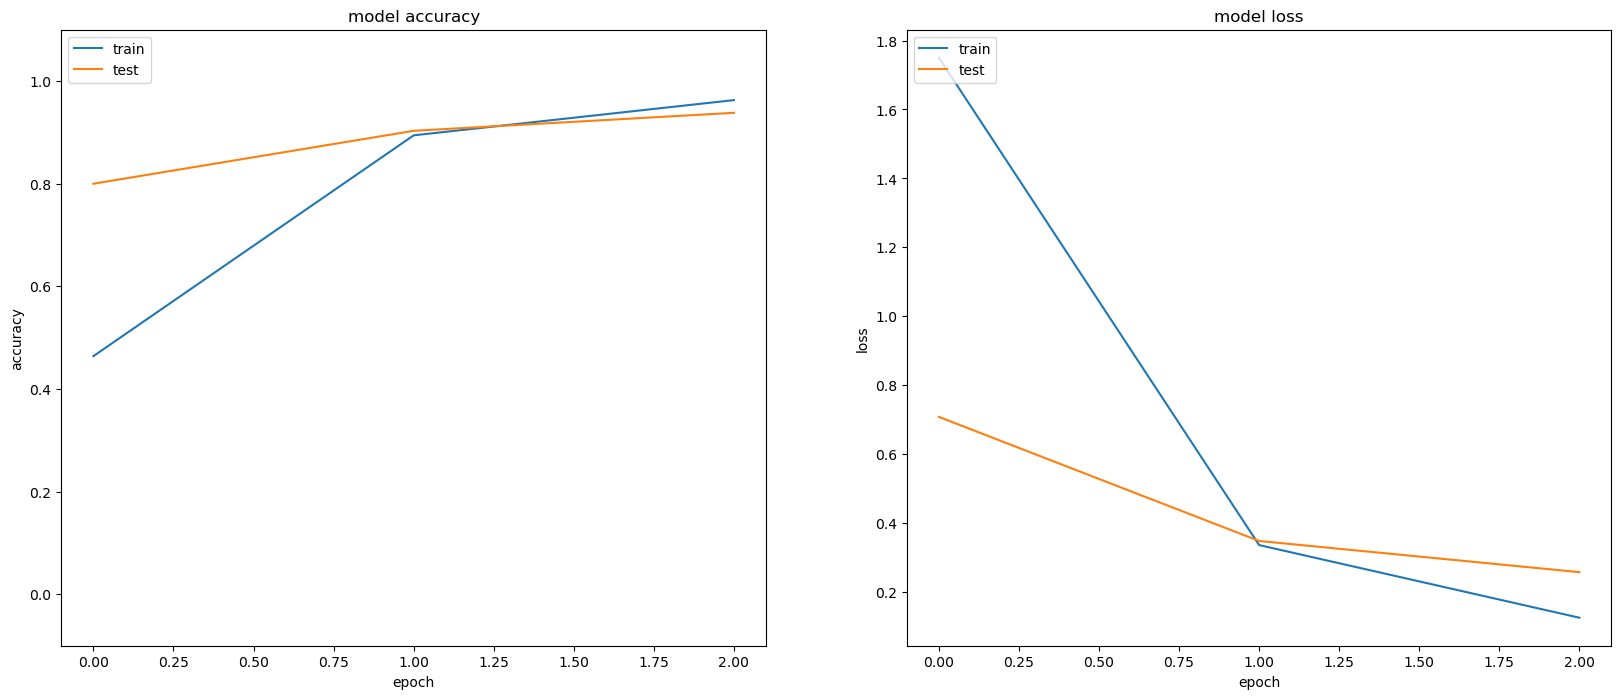

In [49]:
model = create_model(layers=[
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Our second experiment we can see that the early stopping callback has stopped the training as our model was close to overfitting. 

The main observation is that the model started with half of the loss as the previous one and in the second epoch had a significat drop in loss and increase in accuracy. In the middle of the first-second one it looked like it was about to overfit but 

# Experiment 3

This experiment is using 4 Conv2D layers with 64, 128 and 256 filters with BatchNormalization and MaxPooling. 

The network structure is based on a kaggle notebook which states that is the best performing structure on the MNIST dataset (which is similar to our).

We are experimenting with this model to see what kind of results we're getting.

source:
- https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook

Epoch 1/20
76/76 [==============================] - 60s 769ms/step - loss: 0.8447 - accuracy: 0.7232 - val_loss: 0.2754 - val_accuracy: 0.9505
Epoch 2/20
76/76 [==============================] - 51s 667ms/step - loss: 0.1169 - accuracy: 0.9691 - val_loss: 0.1582 - val_accuracy: 0.9653
Epoch 3/20
76/76 [==============================] - 52s 682ms/step - loss: 0.0216 - accuracy: 0.9930 - val_loss: 0.1745 - val_accuracy: 0.9604
Epoch 3: early stopping
76/76 [==============================] - 13s 173ms/step - loss: 0.0237 - accuracy: 0.9942


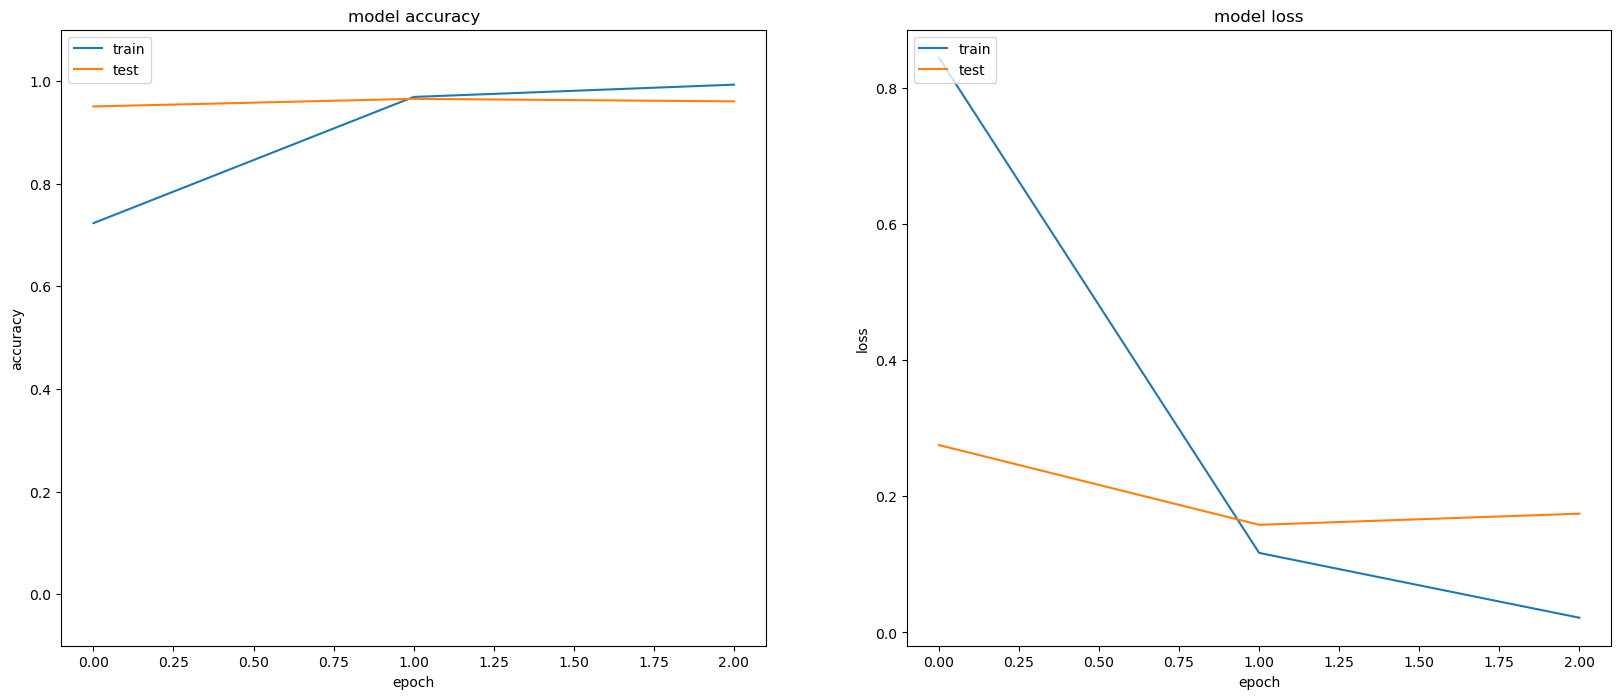

In [50]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(128, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D((2,2)),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Experiment 4

For this experiment we are using the previous structure but we are going to add some dropout layers to see if we can improve the results.

source:
- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

Epoch 1/20
76/76 [==============================] - 42s 516ms/step - loss: 1.4194 - accuracy: 0.5615 - val_loss: 0.4150 - val_accuracy: 0.8894
Epoch 2/20
76/76 [==============================] - 47s 622ms/step - loss: 0.2243 - accuracy: 0.9303 - val_loss: 0.2790 - val_accuracy: 0.9356
Epoch 3/20
76/76 [==============================] - 1190s 16s/step - loss: 0.0774 - accuracy: 0.9814 - val_loss: 0.2104 - val_accuracy: 0.9373
Epoch 3: early stopping
76/76 [==============================] - 13s 175ms/step - loss: 0.0346 - accuracy: 0.9942


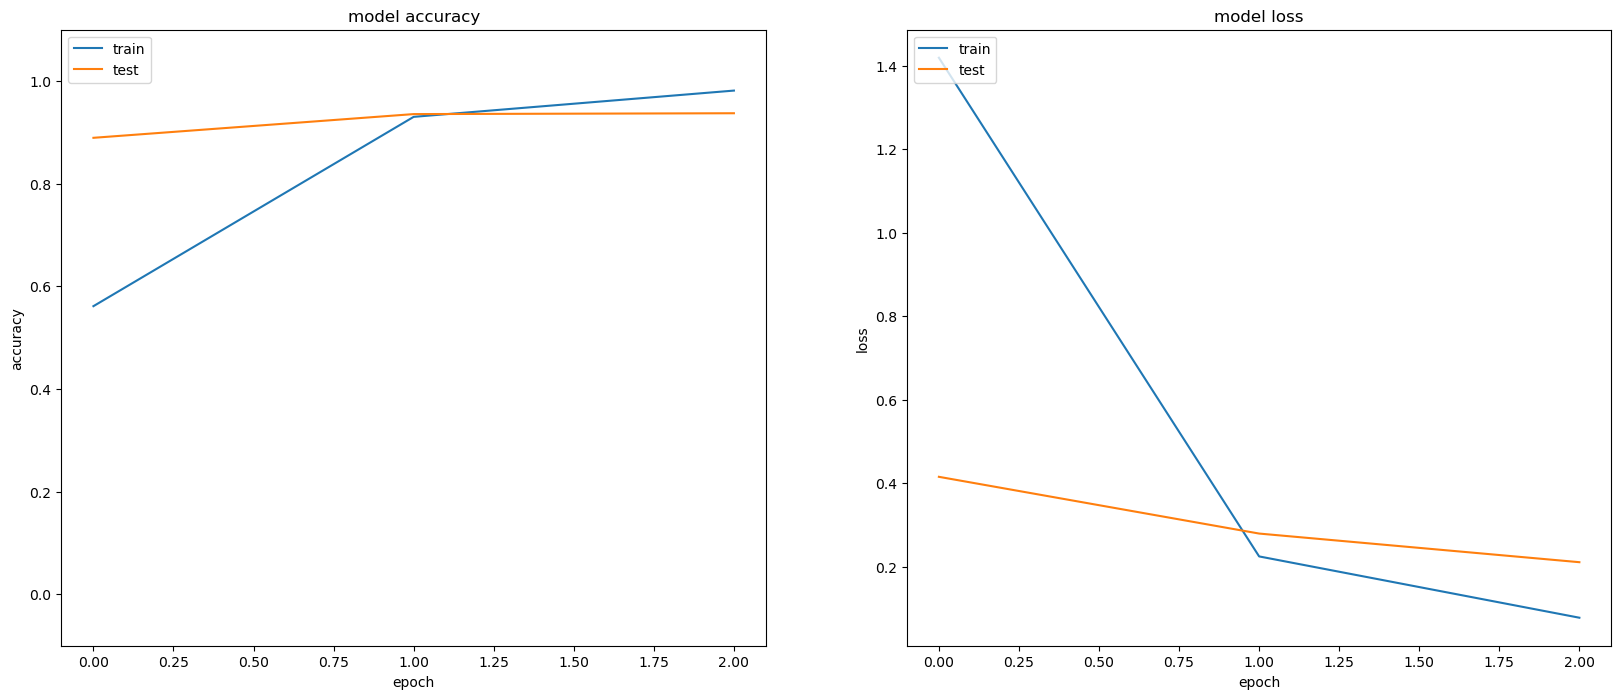

In [51]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64,kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Experiment 5

In our 5th experiment we added data augmentation to see if we can improve the results. As well as 3 Conv2D layers with 64 and 32 filters with BatchNormalization,  MaxPooling and Dropout. 

Epoch 1/20
76/76 [==============================] - 76s 913ms/step - loss: 2.3976 - accuracy: 0.0846 - val_loss: 2.3962 - val_accuracy: 0.1007
Epoch 2/20
76/76 [==============================] - 81s 1s/step - loss: 2.3955 - accuracy: 0.1002 - val_loss: 2.3954 - val_accuracy: 0.0842
Epoch 3/20
76/76 [==============================] - 50s 660ms/step - loss: 2.3946 - accuracy: 0.0982 - val_loss: 2.3955 - val_accuracy: 0.1155
Epoch 3: early stopping
76/76 [==============================] - 12s 156ms/step - loss: 2.3938 - accuracy: 0.1011


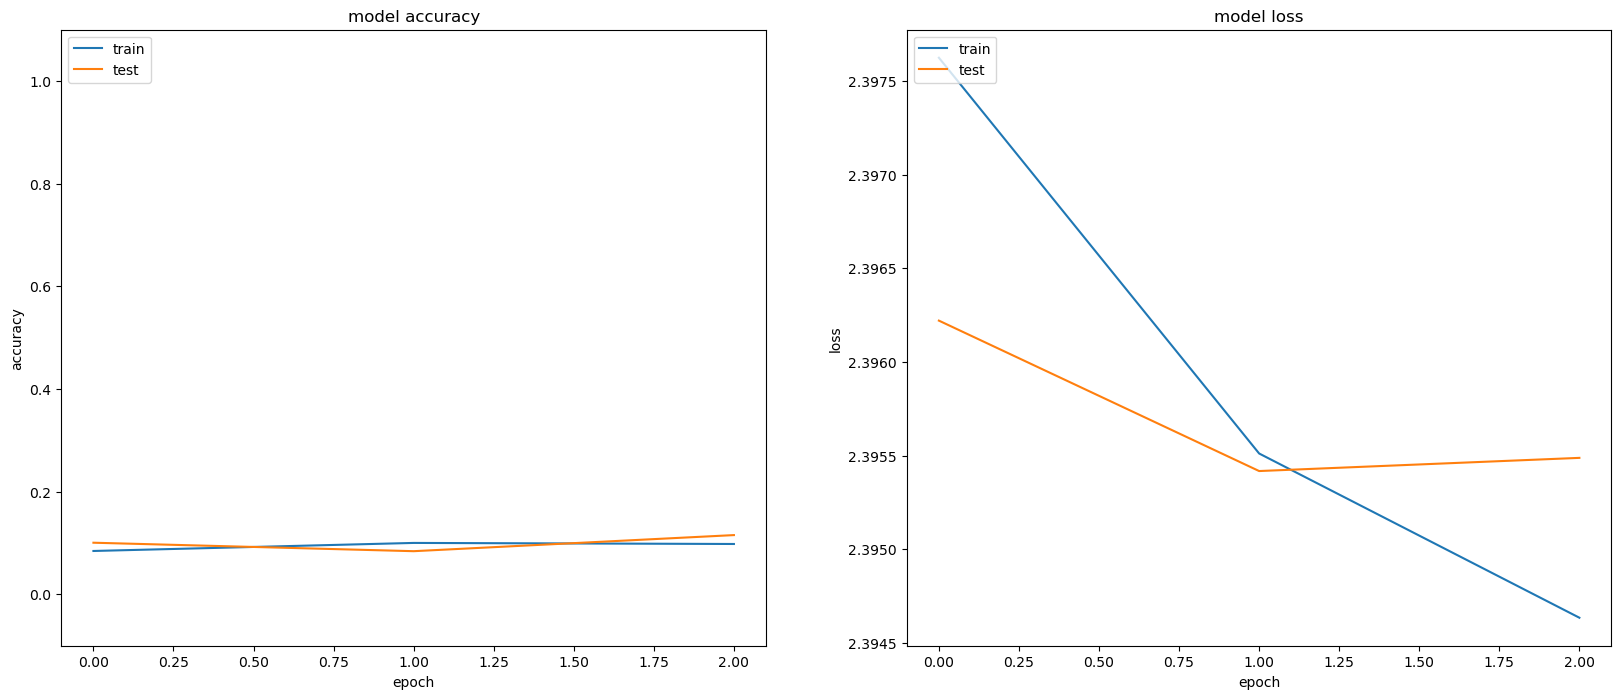

In [52]:
model = create_model(layers=[
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Experiment 6

Our final experiment consists in 3 Conv2D layers with 64 neurons but this time we are adding BatchNormalization and Dropout.

The second experiment had an accuracy of 94% and we would like to see if we can improve it.

source:
- https://www.philschmid.de/image-classification-huggingface-transformers-keras
- https://huggingface.co/google/vit-base-patch16-224

Epoch 1/20
76/76 [==============================] - 113s 1s/step - loss: 1.5768 - accuracy: 0.4550 - val_loss: 3.4173 - val_accuracy: 0.0776
Epoch 2/20
76/76 [==============================] - 63s 833ms/step - loss: 1.0680 - accuracy: 0.6485 - val_loss: 2.2838 - val_accuracy: 0.2475
Epoch 3/20
76/76 [==============================] - 66s 859ms/step - loss: 0.9347 - accuracy: 0.6881 - val_loss: 2.3305 - val_accuracy: 0.1766
Epoch 3: early stopping
76/76 [==============================] - 12s 154ms/step - loss: 2.2933 - accuracy: 0.1885


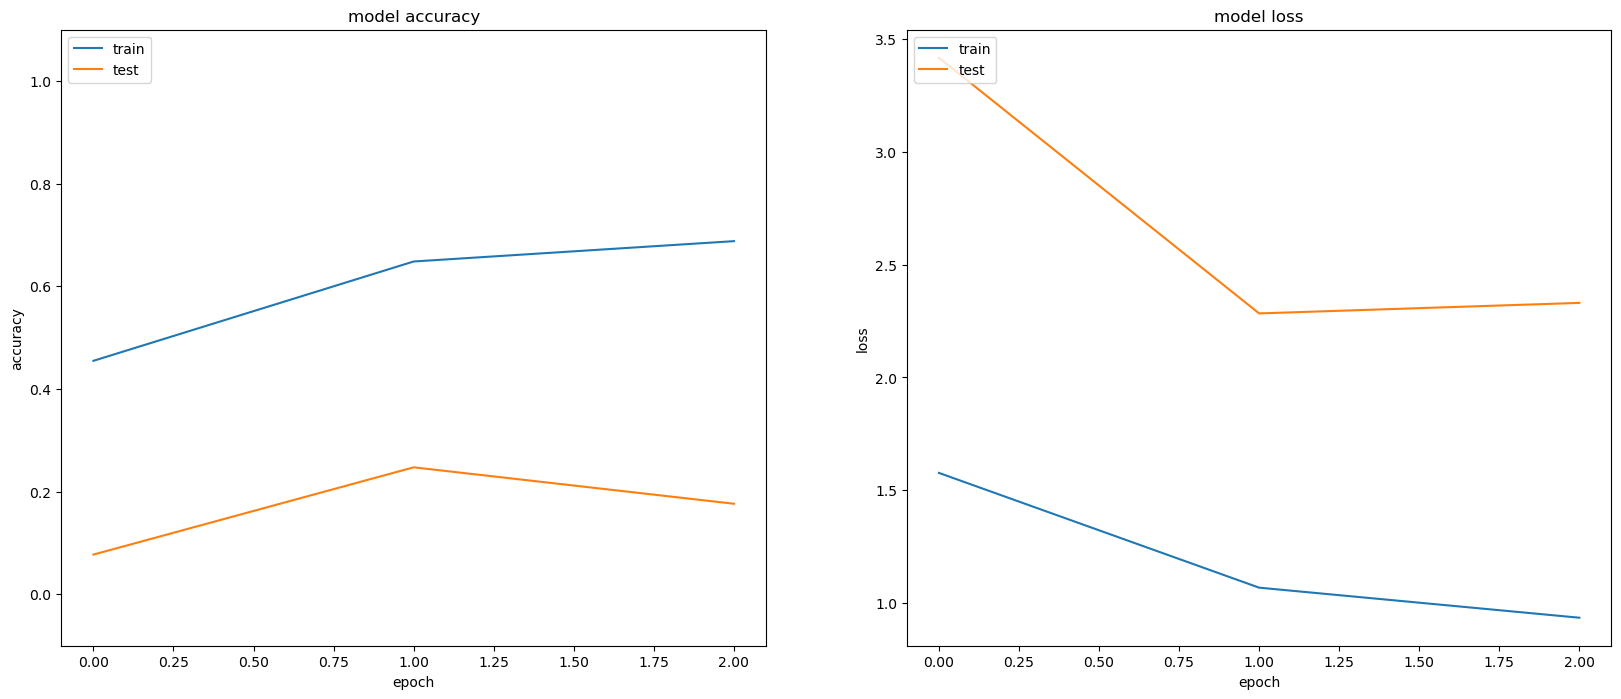

In [53]:
model = create_model(layers=[
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Experiment 7

This experiment is a result of the previous model trained with the data augmentation. We are going to use the same model but we are going to train it without the data augmentation layers. Which apparently is not helping the model to improve the results.

Epoch 1/20
76/76 [==============================] - 61s 784ms/step - loss: 0.8081 - accuracy: 0.7661 - val_loss: 1.4759 - val_accuracy: 0.6601
Epoch 2/20
76/76 [==============================] - 50s 654ms/step - loss: 0.0734 - accuracy: 0.9777 - val_loss: 1.5499 - val_accuracy: 0.6749
Epoch 3/20
76/76 [==============================] - 71s 932ms/step - loss: 0.0258 - accuracy: 0.9938 - val_loss: 0.9796 - val_accuracy: 0.7657
Epoch 3: early stopping
76/76 [==============================] - 12s 151ms/step - loss: 0.8916 - accuracy: 0.7917


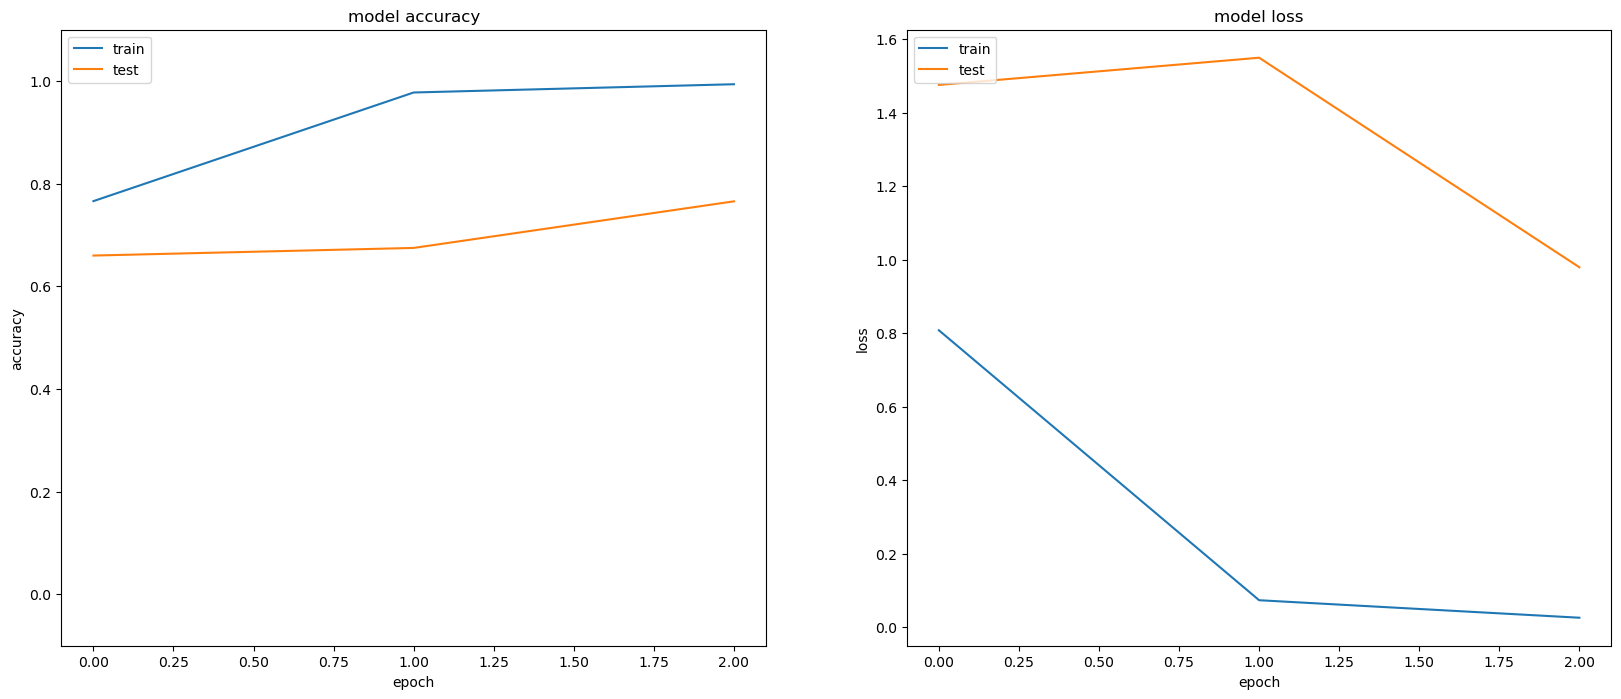

In [54]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

As we can observe from the training the model is performing way better than the previous one. We can see that the validation accuracy is increasing and the validation loss is decreasing if we remove the augmentation layers. However, that being said the resutls obtained are not as good as the most simpliest models that we trained in Experiment 1, Experiment 3 and Experiment 4 which hit the threshhold of 99% validation accuracy. 

Checking the models that we have trained in our experiments

In [55]:
models_and_history

[(<keras.engine.sequential.Sequential at 0x2434559a100>,
  [0.006742600351572037, 1.0]),
 (<keras.engine.sequential.Sequential at 0x2434628c8b0>,
  [0.2441820204257965, 0.9455445408821106]),
 (<keras.engine.sequential.Sequential at 0x24341fdab20>,
  [0.023700054734945297, 0.9942244291305542]),
 (<keras.engine.sequential.Sequential at 0x2432dedaf70>,
  [0.03464643284678459, 0.9942244291305542]),
 (<keras.engine.sequential.Sequential at 0x24345545a00>,
  [2.3938238620758057, 0.10107260942459106]),
 (<keras.engine.sequential.Sequential at 0x243421dbc70>,
  [2.293309450149536, 0.18853135406970978]),
 (<keras.engine.sequential.Sequential at 0x24341b256a0>,
  [0.8915795087814331, 0.7916666865348816])]

# Exporting the best model

In [58]:
best_model, model_history, evaluation_results = models_and_history[3]

Displaying the loss and accuracy of the best model

In [63]:
loss, accuracy = evaluation_results

print(f"Loss: {loss:.7f} - accuracy: {accuracy:.7f}")

Loss: 0.0346464 - accuracy: 0.9942244


Saving the model

In [64]:
best_model.save('best_model_cnn')

INFO:tensorflow:Assets written to: best_model_cnn\assets


Loading the model

In [65]:
model = keras.models.load_model('best_model_cnn')

Analisys of the model

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_mode(model, history):
    model.summary()
    print("\n")
    predictions = model.predict(X_test, verbose=0)
    y_pred = (predictions > 0.5)
    y_test_=y_test.astype(int).tolist()
    print(confusion_matrix(y_test_, y_pred.argmax(axis=1)))
    print("\n")
    print(classification_report(y_true=y_test_,y_pred=y_pred.argmax(axis=1), target_names=np.unique(labels),zero_division=0))
    print("\n")
    
    plot_acc_loss(history)

In [67]:
analyse_my_mode(model, history)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 30, 30, 64)      

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

# Testing the model

Finally we are going to test the model with some images that we have generated with the server from Introduction to Machine Learning. We are going to use only 10 images to test the model.

numpy.ndarray

In [68]:
labels_predicted = model.predict(X_test).argmax(axis=1)
labels_correct = []

for images, labels in X_test:
    labels_correct.extend(labels.numpy().argmax(axis=1))

print("Model confusion matrix")
conf_matrix = tf.math.confusion_matrix(labels=labels_correct, predictions=labels_predicted).numpy()

ValueError: too many values to unpack (expected 2)

# Conclusion

During our experiments we have encountered different situations where our model performed or not as we expected. In the beginning of our experiments the models we have tried different configurations of layers with different number of neurons and different techniques to avoid overfitting, such as using a early stopping callback, dropout layers and data augmentation. 

As an observation, the most simple model that we have trained in Experiment 2, Experiment 3 and Experiment 4 had the best results. Something that we couldn't figure out is why the models with the data augmentation were performing worse than the models without.

In addition to that, the literature that we have checked says that by adding data augmentation, dropout layers and early stopping callbacks we should be able to avoid overfitting. Nevertheless, the we also noticed at some point that we have started training with a very small loss function and in fact for the validation it was higher than the training loss. Same thing happened with the accuracy, training accuracy was quite high and in the validation was lower.